In [1]:
from __future__ import division, print_function

import copy
import os
import random
import shutil
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import splitfolders
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, models, transforms

from cub_dataloader_good import CUB, denormalize, normalize, visualize

print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)

PyTorch Version:  2.0.0
Torchvision Version:  0.15.0


In [2]:
data = './CUB_200_2011/'
num_classes = 200
num_epochs = 30

feature_extract = True

batch_size = 8

In [3]:
seed = 42
print(f'setting everything to seed {seed}')
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

setting everything to seed 42


In [5]:
def normalize():
    return transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])

def denormalize(img):
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return img*imagenet_stats[1] + imagenet_stats[0]

def show_image(img):
  img = img.transpose(1,2,0)
  img= denormalize(img)
  plt.imshow(img)

In [6]:
# Define the image transformations - normalization based on ImageNet parameters
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    normalize(),
    transforms.ToTensor(),
])

In [7]:
PATH = Path('./CUB_200_2011/CUB_200_2011')
labels = pd.read_csv(PATH/"image_class_labels.txt", header=None, sep=" ")
labels.columns = ["id", "label"]
labels.head(2)

,id,label
0,1,1
1,2,1


In [8]:
images = pd.read_csv(PATH/"images.txt", header=None, sep=" ")
images.columns = ["id", "name"]
images.head(2)

,id,name
0,1,001.Black_footed_Albatross/Black_Footed_Albatr...
1,2,001.Black_footed_Albatross/Black_Footed_Albatr...


In [9]:
train_classes = pd.read_csv("./xlsa17/data/CUB/trainvalclasses.txt", header=None, sep=".")
test_classes = pd.read_csv("./xlsa17/data/CUB/testclasses.txt", header=None, sep=".")
image_class_labels = pd.read_csv(PATH/"image_class_labels.txt", header=None, sep=" ")
# images = pd.read_csv(PATH/"images.txt", header=None, sep=" ")

train_images = images.merge(image_class_labels, left_on='id', right_on=0, how="inner").merge(train_classes, how="inner", left_on=1, right_on=0)
train_images['is_train'] = 1
test_images = images.merge(image_class_labels, left_on='id', right_on=0, how="inner").merge(test_classes, how="inner", left_on=1, right_on=0)
test_images['is_train'] = 0

# combine train and test images
train_test = pd.concat([train_images, test_images], axis=0)
train_test.drop(train_test.columns[[0, 2, 3, 4, 5, 6]], axis=1, inplace=True)
train_test.columns = ["id", "is_train"]
train_test = train_test.sort_values(by='id')
train_test = train_test.reset_index(drop=True)

# Separate dataframes for is_train == 1 and is_train == 0
df_train_1 = train_test[train_test['is_train'] == 1]
df_train_0 = train_test[train_test['is_train'] == 0]

# Randomly select half of the rows from each dataframe to drop
drop_indices_1 = np.random.choice(df_train_1.index, size=int(df_train_1.shape[0]/1.2), replace=False)
drop_indices_0 = np.random.choice(df_train_0.index, size=int(df_train_0.shape[0]/1.2), replace=False)

# Drop these rows
train_test = train_test.drop(drop_indices_1)
train_test = train_test.drop(drop_indices_0)
images = images.drop(drop_indices_1)
images = images.drop(drop_indices_0)
labels = labels.drop(drop_indices_1)
labels = labels.drop(drop_indices_0)

print(train_test.shape)
print(images.shape)
print(labels.shape)

(1966, 2)
(1966, 2)
(1966, 2)


In [10]:
classes = pd.read_csv(PATH/"classes.txt", header=None, sep=" ")
classes.columns = ["id", "class"]
classes.head(2)

,id,class
0,1,001.Black_footed_Albatross
1,2,002.Laysan_Albatross


In [11]:
categories = [x for x in classes["class"]]

In [12]:
class_attributes = pd.read_csv(PATH/"attributes/class_attribute_labels_continuous.txt", header=None, sep=" ")

In [13]:
from pathlib import Path

PATH = Path('./CUB_200_2011/CUB_200_2011')

print(labels.shape)
print(train_test.shape)
print(images.shape)

train_dataset = CUB(PATH, labels, train_test, images, train= True, transform= True)
valid_dataset = CUB(PATH, labels, train_test, images, train= False, transform= False)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=32, num_workers=4)

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

(1966, 2)
(1966, 2)
(1966, 2)


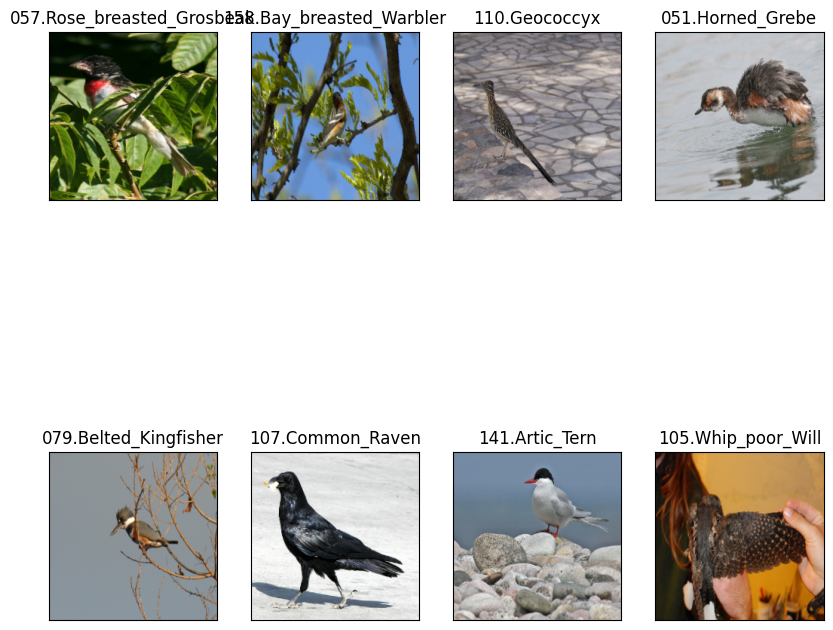

In [14]:
visualize(train_loader, categories)

In [15]:
# Load the pretrained model
resnet = models.resnet101(weights=models.ResNet101_Weights.IMAGENET1K_V2)
resnet.eval()
resnet.to(device)

layer = resnet._modules.get('avgpool')

In [16]:
def get_vector(img):
    img = image_transform(img)
    img = img.unsqueeze(0)
    img = img.to(device)
    my_embedding = torch.zeros(2048)
    def copy_data(m, i, o):
        my_embedding.copy_(o.data.squeeze())
    h = layer.register_forward_hook(copy_data)
    resnet(img)
    h.remove()
    return my_embedding

# get_vector implementation that works with batches
# imgs is a tensor of shape (batch_size, 3, 224, 224) 
def get_vectors(imgs):
    imgs = imgs.to(device)
    my_embeddings = torch.zeros(imgs.shape[0], 2048)
    def copy_data(m, i, o):
        my_embeddings.copy_(o.data.squeeze())
    h = layer.register_forward_hook(copy_data)
    resnet(imgs)
    h.remove()
    return my_embeddings

Image: tensor([[[ 0.2967,  0.2796,  0.2796,  ...,  0.2796,  0.2282,  0.2453],
         [ 0.2967,  0.2967,  0.2967,  ...,  0.2624,  0.2111,  0.2624],
         [ 0.2796,  0.2624,  0.3138,  ...,  0.2453,  0.2624,  0.2967],
         ...,
         [ 0.3309,  0.2967,  0.3138,  ..., -1.6555, -1.6384, -1.6555],
         [ 0.3138,  0.3138,  0.2967,  ..., -1.6384, -1.6384, -1.6555],
         [ 0.3309,  0.3138,  0.2967,  ..., -1.7925, -1.7754, -1.7754]],

        [[ 0.7129,  0.7129,  0.7304,  ...,  0.6954,  0.6779,  0.7129],
         [ 0.7129,  0.7129,  0.7304,  ...,  0.7129,  0.6954,  0.7304],
         [ 0.7129,  0.7129,  0.7304,  ...,  0.6954,  0.6954,  0.7129],
         ...,
         [ 0.7654,  0.7304,  0.7654,  ..., -1.4405, -1.4230, -1.4405],
         [ 0.7654,  0.7479,  0.7479,  ..., -1.4230, -1.4230, -1.4405],
         [ 0.7654,  0.7479,  0.7304,  ..., -1.5805, -1.5630, -1.5630]],

        [[ 1.3154,  1.3154,  1.2980,  ...,  1.2805,  1.2457,  1.2631],
         [ 1.3154,  1.3154,  1.2805,  

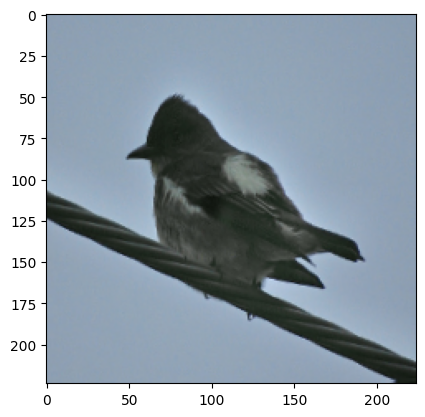

In [17]:
x, y = next(iter(train_loader))
single_image = x[0]
single_label = y[0]

print(f"Image: {single_image}")
print(f"Image shape: {single_image.shape}")
print(f"Label: {single_label}")

inp = single_image.numpy().transpose(1,2,0)
inp = denormalize(inp)
plt.imshow(inp)


single_image.unsqueeze_(0)

# Make sure the image tensor is on the same device as the model
single_image = single_image.to(next(resnet.parameters()).device)

# Make sure image dtype is the same as model's expected input
single_image = single_image.float()

# Apply the model to the image
output = resnet(single_image)

# Get the index corresponding to the maximum score and the maximum score itself.
_, pred = torch.max(output.data, 1)
print(f"Predicted class index: {pred.item()}")
print(f"Predicted class: {categories[pred.item()]}")
print(f"Actual class label: {categories[single_label]}")

print(type(output))
print(output)
print(output.data.shape)

In [18]:
N_TRAIN_CLASSES = len(train_classes)
N_CLASSES = len(train_classes) + len(test_classes)
N = N_TRAIN_CLASSES

N_ENCODER_OUTPUT_NODES = 256

In [19]:
# Implement SE-GZSL networks
# Implement semantic encoder
def make_semantic_encoder():
    return nn.Sequential(
        nn.Linear(2048, 4096),
        nn.LeakyReLU(0.02),
        nn.Linear(4096, N_ENCODER_OUTPUT_NODES)
    )

def make_residual_encoder():
    return nn.Sequential(
        nn.Linear(2048, 4096),
        nn.LeakyReLU(0.02),
        nn.Linear(4096, N_ENCODER_OUTPUT_NODES)
    )

def make_decoder():
    return nn.Sequential(
        nn.Linear(N_ENCODER_OUTPUT_NODES * 2, 2048),
        nn.ReLU()
    )

def make_classifier():
    return nn.Sequential(
        nn.Linear(N_ENCODER_OUTPUT_NODES, N_CLASSES),
        nn.LogSoftmax(dim=1)
    )

# Implement generator
def make_generator():
    # ? how to get the noise vector in here?
    return nn.Sequential(
        nn.Linear(312, 2048),
        nn.ReLU(),
    )

# Implement critic
def make_critic():
    return nn.Sequential(
        nn.Linear(4096, 1),
        nn.LeakyReLU(0.02)
    )


In [20]:
from numpy import dot
from numpy.linalg import norm
import subprocess as sp
import os

def get_gpu_memory():
    command = "nvidia-smi --query-gpu=memory.free --format=csv"
    memory_free_info = sp.check_output(command.split()).decode('ascii').split('\n')[:-1][1:]
    memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]
    return memory_free_values

def cosine_similarity(list_1, list_2):
  cos_sim = torch.dot(list_1, list_2) / (torch.norm(list_1) * torch.norm(list_2))
  return cos_sim

def similiarity_loss(semantic_encoder_outputs):
  semantic_encoder_outputs_dict = {}
  for semantic_encoder_output in semantic_encoder_outputs:
    class_label = semantic_encoder_output[1]
    if class_label in semantic_encoder_outputs_dict:
      semantic_encoder_outputs_dict[class_label].append(semantic_encoder_output[0])
    else:
      semantic_encoder_outputs_dict[class_label] = [semantic_encoder_output[0]]
  
  similiarity_loss = 0
  for label, outputs in semantic_encoder_outputs_dict.items():
    same_class_similarity = 0
    different_class_similarity = 0

    for z_i in outputs:

      # calculate same class similarity
      for z_j in outputs:

        # skip same element
        if torch.equal(z_i, z_j):
          continue

        cos_sim = cosine_similarity(z_i, z_j)
        same_class_similarity += torch.exp(cos_sim)

      # calculate different class similarity
      for label_prime, outputs_prime in semantic_encoder_outputs_dict.items():

        # skip same class
        if label_prime == label:
          continue

        for z_j_prime in outputs_prime:

          cos_sim = cosine_similarity(z_i, z_j_prime)
          different_class_similarity += torch.exp(cos_sim)

    similiarity_loss += torch.log(torch.div(same_class_similarity, different_class_similarity))
    print(similiarity_loss)
    
  return -torch.divide(similiarity_loss, len(train_loader))

In [21]:
def reconstruction_loss(image_features, reconstructed_image_features):
    reconstructed_image_features_dict = {}
    for i in range(len(reconstructed_image_features)):
        reconstructed_image_feature = reconstructed_image_features[i]
        class_label = reconstructed_image_feature[1]
        if class_label in reconstructed_image_features_dict:
            reconstructed_image_features_dict[class_label].append((reconstructed_image_feature[0], image_features[i][0]))
        else:
            reconstructed_image_features_dict[class_label] = [(reconstructed_image_feature[0], image_features[i][0])]
    
    recon_loss = 0
    for label, outputs in reconstructed_image_features_dict.items():
        for x, x_recon in outputs:
            recon_loss += torch.linalg.vector_norm(x - x_recon)
    
    return torch.divide(recon_loss, len(train_loader))


In [22]:
class F_function(nn.Module):
    def __init__(self) -> None:
        super(F_function, self).__init__()
        self.weights = nn.Parameter(torch.randn(N_ENCODER_OUTPUT_NODES, 312) / 10000, requires_grad=True).to(device)
    
    def forward(self, z, a):
        return torch.matmul(torch.matmul(z, self.weights).to(device), a)

In [24]:
from mi_estimators import CLUB, CLUBForCategorical, InfoNCE

class TotalLoss(nn.Module): 
    def __init__(self):
        super(TotalLoss, self).__init__()
        self.info_nce = InfoNCE(N_ENCODER_OUTPUT_NODES, 312, 1024).to(device)
        self.f = F_function().to(device)
    
    def mi_info_nce(self, semantic_encoder_outputs, class_attributes):
        semantic_encoder_outputs_dict = {}
        for semantic_encoder_output in semantic_encoder_outputs:
            class_label = semantic_encoder_output[1]
            if class_label in semantic_encoder_outputs_dict:
                semantic_encoder_outputs_dict[class_label].append(semantic_encoder_output[0].to(device))
            else:
                semantic_encoder_outputs_dict[class_label] = [semantic_encoder_output[0].to(device)]

        info_nce_loss = torch.tensor(0.).requires_grad_()
        for label, outputs in semantic_encoder_outputs_dict.items():
            same_class_mi = torch.tensor(0.).requires_grad_()
            different_class_mi = torch.tensor(0.).requires_grad_()

            for z_i in outputs:
                # calculate same class mi
                a_c_i = class_attributes[label]
                same_class_mi = same_class_mi.add(torch.exp(self.f(z_i, a_c_i)))

                # calculate different class mi
                for label_prime, outputs_prime in semantic_encoder_outputs_dict.items():

                    # skip same class
                    if label_prime == label:
                        continue

                    a_c_prime = class_attributes[label_prime]
                    different_class_mi = torch.add(different_class_mi, torch.exp(self.f(z_i, a_c_prime)))
                
                different_class_mi = torch.divide(different_class_mi, len(semantic_encoder_outputs_dict))
                
                info_nce_loss_step = torch.div(same_class_mi, different_class_mi)
                info_nce_loss = torch.add(info_nce_loss, torch.log(info_nce_loss_step))

        info_nce_loss = info_nce_loss.divide(len(train_loader)) 
        info_nce_loss = info_nce_loss.mul(-1)

        return info_nce_loss

    def mi_loss(self, semantic_output, residual_output, labels):
        cuda_class_attributes = torch.from_numpy(class_attributes.to_numpy()).to(device).to(torch.float32)

        lambda_s = torch.tensor(20) # TODO: tune
        lambda_r = 0.1 # TODO: tune
        semantic_mi_loss = 0
        residual_mi_loss = 0
        
        # club = CLUBForCategorical(4096, 312, 4096).to(device)

        # semantic_mi_loss = -lambda_s * self.info_nce(torch.stack([out for out, label in  semantic_output]).to(device), torch.stack([cuda_class_attributes[label] for out, label in semantic_output]).to(device))

        info_nce_result = self.mi_info_nce(semantic_output, cuda_class_attributes)
        semantic_mi_loss = torch.mul(lambda_s, info_nce_result).mul(-1)

        # residual_mi_loss = lambda_r * club(residual_output, batch_class_attributes)
        mi_loss = torch.add(semantic_mi_loss, residual_mi_loss)
        return mi_loss

    def forward(self, image_features, reconstructed_image_features, semantic_outputs, residual_outputs, labels):
        loss = 0
        loss = torch.add(loss, self.mi_loss(semantic_outputs, residual_outputs, labels)) # + nn.NLLLoss()(output, target)
        loss += similiarity_loss(semantic_outputs)
        loss += reconstruction_loss(image_features, reconstructed_image_features)
        print(loss)
        return loss

In [25]:
# implement custom model
class SE_GZSL(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.semantic_encoder = make_semantic_encoder()
        self.residual_encoder = make_residual_encoder()
        self.decoder = make_decoder()

    def forward(self, image_features):
        semantic_output = self.semantic_encoder(image_features)
        residual_output = self.residual_encoder(image_features)
        reconstructed_image_feature = self.decoder(torch.cat((semantic_output, residual_output), dim=1))
        return reconstructed_image_feature, semantic_output, residual_output

class Generator(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.generator = make_generator()

    def forward(self, noise_vector, attribute_vector):
        generated_image_features = self.generator(torch.cat((noise_vector, attribute_vector), dim=1))
        return generated_image_features

class Critic(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.critic = make_critic()

    def forward(self, image_features):
        critic_output = self.critic(image_features)
        return critic_output
    
class Classifier(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.classifier = make_classifier()

    def forward(self, image_features):
        classifier_output = self.classifier(image_features)
        return classifier_output

In [26]:
# training loop for SE-GZSL

# Initialize the model for this run
se_gzsl = SE_GZSL()

# Print the model we just instantiated
print(se_gzsl)

# Send the model to GPU
se_gzsl = se_gzsl.to(device)

# initialize the optimizer
optimizer = optim.Adam(se_gzsl.parameters(), lr=0.001)
criterion = TotalLoss()

losses = []

# torch.autograd.set_detect_anomaly(True)

for epoch in range(num_epochs):
    # initialize tensor that holds all semantic_output/label pairs
    semantic_outputs = []

    print('passing')
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.to(device).to(torch.float32)
        labels = labels.to(device)

        # extract image features using resnet
        image_features = get_vectors(images).to(device)

        # Forward pass
        reconstructed_image_features, semantic_output, residual_output = se_gzsl(image_features)

        semantic_output = semantic_output.cpu()
        labels = labels.cpu()

        # create pairs of semantic output and label and save them to a tensor
        for i in range(len(semantic_output)):
          semantic_outputs.append([semantic_output[i], labels[i].item()])

        # write the above in a more torchy way

    label_set = set()
    for out in semantic_outputs:
      label_set.add(out[1])
    
    print('n of unique labels: ', len(label_set))
    print(label_set)

    torch.cuda.empty_cache()
    
    loss = criterion(image_features, reconstructed_image_features, semantic_outputs, None, labels)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

SE_GZSL(
  (semantic_encoder): Sequential(
    (0): Linear(in_features=2048, out_features=4096, bias=True)
    (1): LeakyReLU(negative_slope=0.02)
    (2): Linear(in_features=4096, out_features=256, bias=True)
  )
  (residual_encoder): Sequential(
    (0): Linear(in_features=2048, out_features=4096, bias=True)
    (1): LeakyReLU(negative_slope=0.02)
    (2): Linear(in_features=4096, out_features=256, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=512, out_features=2048, bias=True)
    (1): ReLU()
  )
)
passing
n of unique labels:  150
{0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 26, 28, 29, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 43, 45, 46, 47, 49, 50, 52, 53, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70, 72, 73, 74, 75, 77, 78, 79, 80, 81, 82, 84, 85, 87, 88, 89, 91, 92, 94, 95, 98, 99, 100, 101, 104, 105, 106, 107, 108, 109, 111, 113, 114, 115, 116, 117, 119, 120, 121, 124, 125, 127, 128, 130, 132, 133, 134, 136, 

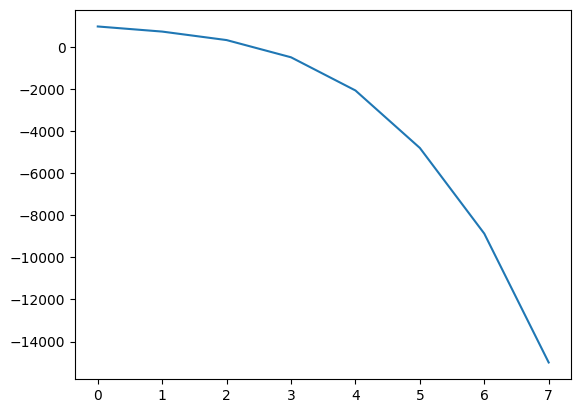

In [27]:
# plot loss
plt.plot(losses)
plt.show()

In [28]:
from wgan_gradient_penalty import WGAN_GP

# get semantic encoder from SE-GZSL
semantic_encoder = se_gzsl.semantic_encoder

# initialize generator
wgan = WGAN_GP(cuda=True)

ModuleNotFoundError: No module named 'utils'